# <机器学习实战 > 之决策树学习

> 决策树的一个重要的任务是为了理解数据中所蕴含的知识信息， 因此决策树可以使用不熟悉的数据集合，并且从中提取出一系列规则，这些机器根据数据集创建规则的过程，就是机器学习的过程， (书中摘要)

### 导入所需要的包

In [81]:
from math import log
import operator

### 计算香农熵

数学公式
信息定义: $$ \iota (x_i) = -log_2p(x_i) $$
其中 $p(x_i)$是选择该分类的概率

为了计算熵，我们需要计算所有分类所有可能值包含的信息期望值
$$ H = - \sum _{i=1} ^{n}p(x_i) log_2 p(x_i) $$

参考的数学公式地址:
> https://www.jianshu.com/p/93ccc63e5a1b 

> https://www.zhihu.com/question/59392251 

> https://oiltang.com/2014/05/04/markdown-and-mathjax/ 

> https://blog.csdn.net/qq_39232265/article/details/78868487 

In [82]:
#计算信息墒
#备注：主要用list中最后一个element为label
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0

        labelCounts[currentLabel] += 1
    shannonEnt = 0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob, 2)

    return shannonEnt

获取数据函数

In [83]:
def createDataSet():
    dataSet = [
        [1, 1, 'yes'],
        [1, 1, 'yes'],
        [1, 0, 'no'],
        [0, 1, 'no'],
        [0, 1, 'no'],
    ]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

In [84]:
myDat, labels = createDataSet()

In [85]:
#通用计算结果
#print(2/5 * log(2/5, 2) + 3/5*log(3/5,2))
print(calcShannonEnt(myDat))

0.9709505944546686


熵越高， 则混入的数据也越多， 我们可以在数据集中添加更多的分类， 观察熵是如何变化的， 现在我们增加第三个名maybe的分类， 测试熵的变化

In [86]:
myDat[0][-1] = 'mybe'
print(myDat)
print(calcShannonEnt(myDat))

[[1, 1, 'mybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
1.3709505944546687


In [87]:
myDat[2][-1] = 'mybe1'
print(myDat)
print(calcShannonEnt(myDat))

[[1, 1, 'mybe'], [1, 1, 'yes'], [1, 0, 'mybe1'], [0, 1, 'no'], [0, 1, 'no']]
1.9219280948873623


### 按照给定的特征划分数据集

In [88]:
def splitDataSet(dataSet, axis, value):
    #创建特征
    retDataSet = []
    #抽取特征
    for featVec in dataSet:
        if featVec[axis] == value:
            reduceFeatVec = featVec[:axis]
            reduceFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reduceFeatVec)
    return retDataSet

In [89]:
myDat, labels = createDataSet()

In [90]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [91]:
splitDataSet(myDat, 0, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [92]:
splitDataSet(myDat, 0, 0)

[[1, 'no'], [1, 'no']]

### 选择最好的数据集划分方式

信息增益是熵的减少或者是无序度的减少，将熵用于度量数据无序度的减少更容易理解

In [101]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    #初始化数据
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
            #print(newEntropy)
        print(newEntropy)
        print(baseEntropy)
        infoGain = baseEntropy - newEntropy
        #print(infoGain)
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

测试验证最好的数据集划分

In [102]:
myDat, labels = createDataSet()
chooseBestFeatureToSplit(myDat)

0.5509775004326937
0.9709505944546686
0.8
0.9709505944546686


0

In [16]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

### 递归构建决策树

工作原理如下： 得到原始数据集， 根据最好的属性值划分数据集， 由于特征可能多余两个，可能存在大于两个分支的数据集合划分， 第一次划分之后， 数据
将被传递道树分之的下一个节点，在这个节点上， 我们可以再次划分数据，因此我们可以采用递归的方式处理数据集

递归结束的条件是： 程序遍历完所有的划分数据集的属性， 或者每个分支下所有的实例都具有相同的分类，如果所有的时例都具有相同的分类，则得到
一个叶子节点，或者终止块，任何到达叶子节点的数据必然属于叶子节点的分类

In [17]:
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    #py2: dict.iteritems(), py3 dict.items()
    sortedClassCount = sorted(classCount.items(), \
                             key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

### 创建树的函数代码

In [18]:
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    #类别完全相同
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    #遍历完所有特征时， 返回出现次数最多的特征
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel : {}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree
    
    

In [19]:
myDat, labels = createDataSet()
myTree = createTree(myDat, labels)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

### matplotlib注解绘制图形

In [20]:
#使用文本注解绘制树节点
import matplotlib.pyplot as plt

#定义基本参数
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,\
    xycoords='axes fraction', xytext=centerPt, textcoords='axes fraction',\
    va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)
def createPlot():
    fig = plt.figure(1, facecolor="white")
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False)
    #TODO 解决matplotlib中文不展示问题
    plotNode('a decision Node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('a leaf Node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

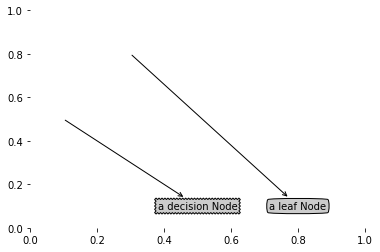

In [21]:
#测试相关代码
createPlot()

In [22]:
#获取叶节点的数目
def getNumLeafs(myTree):
    numLeafs = 0
    #print(list(myTree.keys())[0])
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

In [23]:
#获取树的层数
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

In [24]:
#获取预先存储的树信息
def retrieveTree(i):
    listOfTrees = [
        {'no surfacing': {0: 'no', 1: {'flippers':\
            {0: 'no', 1: 'yes'}}}},
        {'no surfacing': {0: 'no', 1: {'flippers': \
            {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
    ]
    return listOfTrees[i]

In [25]:
retrieveTree(1)

{'no surfacing': {0: 'no',
  1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}

In [26]:
retrieveTree(0)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [27]:
myTree = retrieveTree(0)
print(getNumLeafs(myTree))
print(getTreeDepth(myTree))

3
2


In [49]:
#在父子节点间填充文本信息
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] -cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)
#计算宽与高
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt,str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW;
    plotTree.yOff = 1.0;
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

In [50]:
#检测效果
myTree = retrieveTree(0)


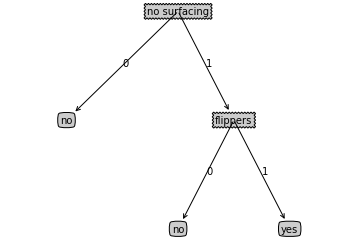

In [52]:
#没有坐标轴
createPlot(myTree)

In [53]:
#变更字典， 重新绘制树形图
myTree['no surfacing'][3] = "maybe"
print(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}}


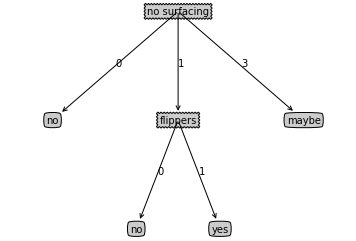

In [54]:
createPlot(myTree)

### 测试算法，使用决策树执行分类
在执行数据分类时， 需要使用决策树以及使用构造决策树的标签向量， 然后程序比较测试数据与决策树上的数值， 递归执行该过程直到进入叶子节点， 最后将测试数据定义为叶子节点所属的类型

In [64]:
#使用决策树的分类函数
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [65]:
myDat, labels = createDataSet()
print(labels)

myTree = retrieveTree(0)
print(myTree)

['no surfacing', 'flippers']
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


In [66]:
classify(myTree, labels, [1, 0])

'no'

In [67]:
classify(myTree, labels, [1, 1])

'yes'

### 使用pickle模块存储决策树

In [74]:
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename, 'wb') #书中写错
    pickle.dump(inputTree, fw)
    fw.close()

def loadTree(filename):
    import pickle
    fr = open(filename, 'rb') #书中写错
    return pickle.load(fr)

In [75]:
#验证pickle 模块
#print(myTree)
storeTree(myTree, 'classifierStorage.txt')


In [76]:
loadTree('classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}